# Experimento de Indexação Hash no PostgreSQL

In [3]:
from utils.db_connection import DatabaseConnection

In [4]:
# Imports necessários
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.db_connection import DatabaseConnection, execute_query
from utils.data_generator import BibliotecaDataGenerator
import numpy as npd

In [5]:
# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

In [6]:
# Inicializa a conexão com o banco de dados
DatabaseConnection.init_connection_pool()

# Cria uma instância do gerador de dados
gerador = BibliotecaDataGenerator(seed=42)

# Limpa o banco de dados para começar do zero
gerador.limpar_banco()
print("Banco de dados limpo e pronto para o experimento.")

Pool de conexão inicializado com sucesso
Limpando o banco de dados...
Banco de dados limpo com sucesso.
Banco de dados limpo e pronto para o experimento.


In [7]:
# Definição da consulta SQL
query = """
SELECT l.titulo, l.publicado_em
FROM livros l
WHERE l.genero = 'História'
AND l.publicado_em >= '2010-01-01'
ORDER BY l.publicado_em DESC;
"""
# Função para executar consulta com EXPLAIN ANALYZE e medir tempo
def executar_consulta_com_tempo(query, collect_stats=True):
    plan_stats = None
    if collect_stats:
        # Versão com EXPLAIN ANALYZE para obter estatísticas
        explain_query = f"EXPLAIN (ANALYZE, BUFFERS, FORMAT JSON) {query}"
        resultado_explain = execute_query(explain_query)

        # Extrair estatísticas
        plan_stats = resultado_explain.values[0][0][0]["Plan"]

    inicio = time.time()
    # Versão simples sem estatísticas
    resultado = execute_query(query)

    fim = time.time()
    tempo_execucao = fim - inicio

    return resultado, tempo_execucao, plan_stats
    
# Função para extrair informações sobre leituras de disco do plano de execução
def extrair_leituras_de_disco(plan_stats):
    """
    Extrai o número total de leituras de disco (shared_read + local_read) de um plano de execução.
    """
    if not plan_stats:
        return 0
        
    total_reads = 0
    
    # Processar o nó atual
    if 'Shared Read Blocks' in plan_stats:
        total_reads += plan_stats['Shared Read Blocks']
    if 'Local Read Blocks' in plan_stats:
        total_reads += plan_stats['Local Read Blocks']
    
    # Processar recursivamente os nós filhos
    if 'Plans' in plan_stats:
        for subplan in plan_stats['Plans']:
            total_reads += extrair_leituras_de_disco(subplan)
    
    return total_reads

# Função para criar índices btree
def criar_indices_btree():
    indices_sql = [
        "CREATE INDEX IF NOT EXISTS idx_livros_genero_publicado ON livros(genero, publicado_em DESC);"
    ]
    
    print("Criando índices árvores...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices árvores criados com sucesso.")

# Função para remover índices btree
def remover_indices_btree():
    indices_sql = [
        "DROP INDEX IF EXISTS idx_livros_genero_publicado;"
    ]
    
    print("Removendo índices árvores...")
    for sql in indices_sql:
        execute_query(sql)
    print("Índices árvores removidos com sucesso.")

In [8]:
# Parâmetros do experimento
num_iteracoes = 8
registros_por_iteracao = 250000
proporcao_usuarios = 0.10  # 10% dos registros serão usuários
proporcao_livros = 0.30    # 30% dos registros serão livros
proporcao_emprestimos = 0.60  # 60% dos registros serão empréstimos

# Armazenar resultados
resultados_experimento = {
    "total_registros": [],
    "tempo_sem_indices": [],
    "tempo_com_indices": [],
    "num_resultados": [],
    "leituras_sem_indices": [],
    "leituras_com_indices": [],
}

# Registrar total inicial
total_registros = 0

# Loop de experimento: adicionar dados e medir tempo
for i in range(0, num_iteracoes):
    print(f"\n{'=' * 50}")
    print(f"ITERAÇÃO {i + 1}: Adicionando mais {registros_por_iteracao} registros...")
    print(f"{'=' * 50}")

    # Calcular quantos registros de cada tipo adicionar
    adicionar_usuarios = int(registros_por_iteracao * proporcao_usuarios)
    adicionar_livros = int(registros_por_iteracao * proporcao_livros)
    adicionar_emprestimos = registros_por_iteracao - adicionar_usuarios - adicionar_livros

    # Adicionar registros
    resultado_batch = gerador.popular_banco(
        num_usuarios=adicionar_usuarios,
        num_livros=adicionar_livros,
        num_emprestimos=adicionar_emprestimos,
    )

    # Atualizar total de registros
    registros_adicionados = sum(resultado_batch.values())
    total_registros += registros_adicionados
    resultados_experimento["total_registros"].append(total_registros)

    print(f"\nTotal de registros agora: {total_registros}")

    # 1. Executar consulta SEM índices e medir tempo
    print("\n1. Executando consulta SEM índices...")
    resultado, tempo_sem_indices, stats_sem_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_sem_indices"].append(tempo_sem_indices)
    resultados_experimento["num_resultados"].append(len(resultado))

    # Extrair leituras de disco
    leituras_sem_indices = extrair_leituras_de_disco(stats_sem_indices)
    resultados_experimento["leituras_sem_indices"].append(leituras_sem_indices)

    print(
        f"Consulta SEM índices executada em {tempo_sem_indices:.4f} segundos, retornando {len(resultado)} registros."
    )
    print(f"Número de leituras de disco sem índices: {leituras_sem_indices}")

    # 2. Criar índices B-Tree
    print("\n2. Criando índices B-Tree...")
    criar_indices_btree()

    # 3. Executar consulta COM índices B-Tree e medir tempo
    print("\n3. Executando consulta COM índices B-Tree...")
    resultado, tempo_com_indices, stats_com_indices = executar_consulta_com_tempo(query)
    resultados_experimento["tempo_com_indices"].append(tempo_com_indices)

    # Extrair leituras de disco
    leituras_com_indices = extrair_leituras_de_disco(stats_com_indices)
    resultados_experimento["leituras_com_indices"].append(leituras_com_indices)

    print(
        f"Consulta COM índices B-Tree executada em {tempo_com_indices:.4f} segundos, retornando {len(resultado)} registros."
    )
    print(f"Número de leituras de disco com índices: {leituras_com_indices}")

    # 4. Remover índices para a próxima iteração
    print("\n4. Removendo índices B-Tree para a próxima iteração...")
    remover_indices_btree()

print("\nExperimento concluído com sucesso!")



ITERAÇÃO 1: Adicionando mais 250000 registros...
Iniciando populamento do banco de dados...
Esquema criado com sucesso.
Gerando 25000 usuários...
Total de 22313 usuários inseridos.
Gerando 75000 livros...
Total de 75000 livros inseridos.
Gerando 150000 empréstimos...
Total de 150000 empréstimos inseridos.
Populamento do banco de dados concluído!

Total de registros agora: 247313

1. Executando consulta SEM índices...
Consulta SEM índices executada em 0.0290 segundos, retornando 555 registros.
Número de leituras de disco sem índices: 0

2. Criando índices B-Tree...
Criando índices árvores...
Índices árvores criados com sucesso.

3. Executando consulta COM índices B-Tree...
Consulta COM índices B-Tree executada em 0.0023 segundos, retornando 555 registros.
Número de leituras de disco com índices: 15

4. Removendo índices B-Tree para a próxima iteração...
Removendo índices árvores...
Índices árvores removidos com sucesso.

ITERAÇÃO 2: Adicionando mais 250000 registros...
Iniciando popula

Resultados do Experimento:
   Total de Registros  Tempo sem Índices (s)  Tempo com Índices B-Tree (s)  \
0              247313               0.029022                      0.002338   
1              491039               0.187974                      0.005533   
2              732299               0.064598                      0.008119   
3              971946               0.098328                      0.006172   
4             1210186               0.103602                      0.008233   
5             1447488               0.178538                      0.012134   
6             1683886               0.152411                      0.011428   
7             1919365               0.176699                      0.012702   

   Leituras de Disco sem Índices  Leituras de Disco com Índices  \
0                              0                             15   
1                              0                             21   
2                           1942                            115   
3 

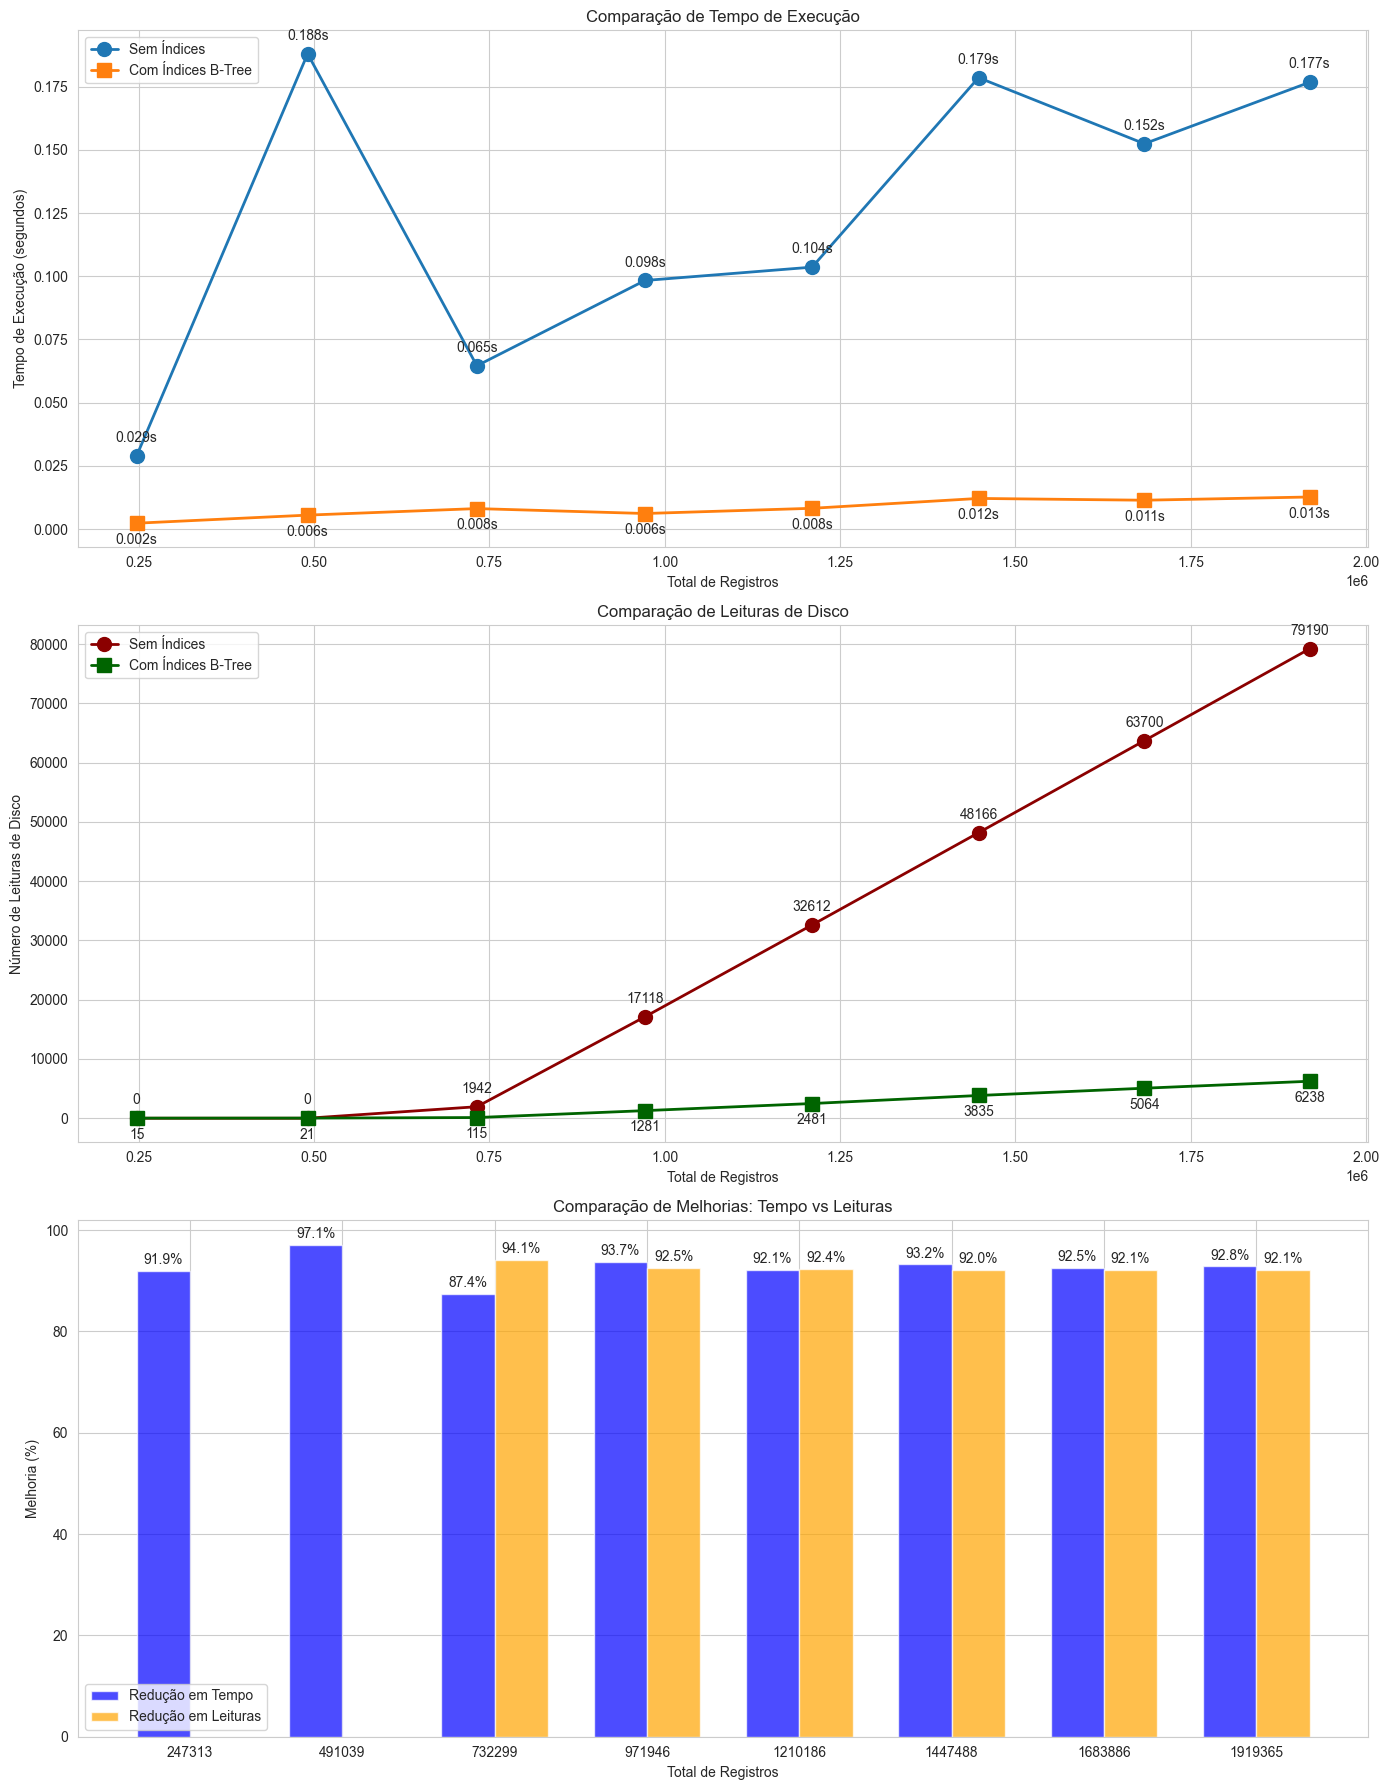

In [12]:
# Criar DataFrame com os resultados
df_resultados = pd.DataFrame({
    'Total de Registros': resultados_experimento['total_registros'],
    'Tempo sem Índices (s)': resultados_experimento['tempo_sem_indices'],
    'Tempo com Índices B-Tree (s)': resultados_experimento['tempo_com_indices'],
    'Leituras de Disco sem Índices': resultados_experimento['leituras_sem_indices'],
    'Leituras de Disco com Índices': resultados_experimento['leituras_com_indices'],
    'Número de Resultados': resultados_experimento['num_resultados'],
})

# Calcular as melhorias percentuais
df_resultados['Melhoria em Tempo (%)'] = (1 - df_resultados['Tempo com Índices B-Tree (s)'] / df_resultados['Tempo sem Índices (s)']) * 100
df_resultados['Redução em Leituras (%)'] = (1 - df_resultados['Leituras de Disco com Índices'] / df_resultados['Leituras de Disco sem Índices']) * 100

# Exibir tabela de resultados
print("Resultados do Experimento:")
print(df_resultados)

# Criar três subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18))

# 1. Gráfico de tempo de execução
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo sem Índices (s)'], 'o-', linewidth=2, markersize=10, label='Sem Índices')
ax1.plot(df_resultados['Total de Registros'], df_resultados['Tempo com Índices B-Tree (s)'], 's-', linewidth=2, markersize=10, label='Com Índices B-Tree')
ax1.set_xlabel('Total de Registros')
ax1.set_ylabel('Tempo de Execução (segundos)')
ax1.set_title('Comparação de Tempo de Execução')
ax1.legend()
ax1.grid(True)

# Adicionar rótulos
for i, row in df_resultados.iterrows():
    ax1.annotate(f"{row['Tempo sem Índices (s)']:.3f}s",
                 xy=(row['Total de Registros'], row['Tempo sem Índices (s)']),
                 textcoords="offset points", xytext=(0,10), ha='center')
    ax1.annotate(f"{row['Tempo com Índices B-Tree (s)']:.3f}s",
                 xy=(row['Total de Registros'], row['Tempo com Índices B-Tree (s)']),
                 textcoords="offset points", xytext=(0,-15), ha='center')

# 2. Gráfico de leituras de disco
ax2.plot(df_resultados['Total de Registros'], df_resultados['Leituras de Disco sem Índices'], 'o-', linewidth=2, markersize=10, color='darkred', label='Sem Índices')
ax2.plot(df_resultados['Total de Registros'], df_resultados['Leituras de Disco com Índices'], 's-', linewidth=2, markersize=10, color='darkgreen', label='Com Índices B-Tree')
ax2.set_xlabel('Total de Registros')
ax2.set_ylabel('Número de Leituras de Disco')
ax2.set_title('Comparação de Leituras de Disco')
ax2.legend()
ax2.grid(True)

# Adicionar rótulos
for i, row in df_resultados.iterrows():
    ax2.annotate(f"{int(row['Leituras de Disco sem Índices'])}",
                 xy=(row['Total de Registros'], row['Leituras de Disco sem Índices']),
                 textcoords="offset points", xytext=(0,10), ha='center')
    ax2.annotate(f"{int(row['Leituras de Disco com Índices'])}",
                 xy=(row['Total de Registros'], row['Leituras de Disco com Índices']),
                 textcoords="offset points", xytext=(0,-15), ha='center')

# 3. Gráfico de barras para percentual de melhoria (tempo e leituras)
width = 0.35
x = df_resultados['Total de Registros']
x_pos = range(len(x))

ax3.bar(npd.array(x_pos) - width/2, df_resultados['Melhoria em Tempo (%)'], width, label='Redução em Tempo', color='blue', alpha=0.7)
ax3.bar(npd.array(x_pos) + width/2, df_resultados['Redução em Leituras (%)'], width, label='Redução em Leituras', color='orange', alpha=0.7)
ax3.set_xlabel('Total de Registros')
ax3.set_ylabel('Melhoria (%)')
ax3.set_title('Comparação de Melhorias: Tempo vs Leituras')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(df_resultados['Total de Registros'])
ax3.legend()
ax3.grid(True, axis='y')

# Adicionar valores em cada barra
for i, row in df_resultados.iterrows():
    ax3.annotate(f"{row['Melhoria em Tempo (%)']:.1f}%",
                 xy=(i - width/2, row['Melhoria em Tempo (%)']),
                 textcoords="offset points", xytext=(0,5), ha='center')
    ax3.annotate(f"{row['Redução em Leituras (%)']:.1f}%",
                 xy=(i + width/2, row['Redução em Leituras (%)']),
                 textcoords="offset points", xytext=(0,5), ha='center')

plt.tight_layout()
plt.show()


In [11]:
# Fechar conexões com o banco de dados ao finalizar
DatabaseConnection.close_all_connections()